# Clickabit detection using informativeness measures

In [141]:
import warnings
import unicodedata

import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import textstat
from lexical_diversity import lex_div

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/tymek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Metrics

In [71]:
def number_of_words(text):
    """ calculates number of words """
    return len(text.split())

def number_of_characters(text):
    """ calculates number of characters including whitespaces """
    return len(text.strip())

def common_words_percentage(text, language="english"):
    """ percentage of stop words in text """
    words = text.split()
    stop_words = stopwords.words(language)
    common_words = [word for word in words if word.lower() in stop_words]
    return len(common_words) / len(words)

def type_token_ratio(text):
    """ lexical richness """
    words = text.split()
    unique_words = set(words)
    return len(unique_words) / len(words)

def corrected_type_token_ratio(text):
    """ lexical richness """
    words = text.split()
    unique_words = set(words)
    return len(unique_words) / np.sqrt(2 * len(words))

def hdd_metric(text):
    """ hypergeometric distribution D, lexical diversity """
    words = text.split()
    if len(words) < 42:
        message = f"The text is {len(words)} words long. HD-D metric is not defined for texts with less than 42 tokens."
        warnings.warn(message, UserWarning)
    return lex_div.hdd(words)

def flesch_reading_ease_score(text):
    """ difficulty of the text, if its easy to read or not 
    
    Formula:
    206.835 - 1.015 * (total words / total sentences) - 84.6 (total syllables / total words)

    Scores:
    -90.00  	Very easy to read. Easily understood by an average 11-year-old student.
    90.0-80.0	Easy to read. Conversational English for consumers.
    80.0-70.0	Fairly easy to read.
    70.0-60.0	Plain English. Easily understood by 13- to 15-year-old students.
    60.0-50.0	Fairly difficult to read.
    50.0-30.0	Difficult to read.
    30.0-10.0	Very difficult to read. Best understood by university graduates.
    10.0-   	Extremely difficult to read. Best understood by university graduates.
    source: https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests
    """
    return textstat.flesch_reading_ease(text)

def flesch_kincaid_grade_level(text):
    """ difficulty of the text, US grade level needed to understand the text quite easily

    Formula:
    0.39 * (total words / total sentences) + 11.8(total syllables / total words) - 15.59

    can also mean the number of years of education generally required to understand this text, relevant when the formula results in a number greater than 10
    source: https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests
    """
    return textstat.flesch_kincaid_grade(text)

def automated_readability_index(text):
    """ difficulty of the text, US grade level necessary to comprehend the text 

    Formula:
    4.71 * (characters / words) + 0.5 (words / sentences) - 21.43

    Scores:
    score | age | grade level
    1	5-6	    Kindergarten
    2	6-7	    First Grade
    3	7-8	    Second Grade
    4	8-9	    Third Grade
    5	9-10	Fourth Grade
    6	10-11	Fifth Grade
    7	11-12	Sixth Grade
    8	12-13	Seventh Grade
    9	13-14	Eighth Grade
    10	14-15	Ninth Grade
    11	15-16	Tenth Grade
    12	16-17	Eleventh Grade
    13	17-18	Twelfth Grade
    14	18-22	College student
    source: https://en.wikipedia.org/wiki/Automated_readability_index
    """
    return textstat.automated_readability_index(text)


In [137]:
metrics_functions = {
    "n_words": number_of_words,
    "n_characters": number_of_characters,
    "cw_percentage": common_words_percentage,
    "ttr": type_token_ratio,
    "cttr": corrected_type_token_ratio,
    "hdd": hdd_metric,
    "fres": flesch_reading_ease_score,
    "fkgl": flesch_kincaid_grade_level,
    "ari": automated_readability_index
}

## Preprocessing

In [240]:
raw_data = pd.read_csv("data/cc_dataset_balanced.csv")

In [241]:
# drop NA
raw_data = raw_data.drop(raw_data[raw_data['body'].isna()].index)
data = raw_data.copy()

In [242]:
# clean escape characters
data['body'] = data['body'].apply(lambda x: unicodedata.normalize('NFKC', x))

## EDA

#### Title analysis

In [243]:
data_metrics = data.copy()

In [244]:
# apply metrics
for name, function in metrics_functions.items():
    if name != "hdd":
        data_metrics[name] = data_metrics['title'].apply(function)

array([[<Axes: title={'center': 'clickbait'}>,
        <Axes: title={'center': 'n_words'}>,
        <Axes: title={'center': 'n_characters'}>],
       [<Axes: title={'center': 'cw_percentage'}>,
        <Axes: title={'center': 'ttr'}>,
        <Axes: title={'center': 'cttr'}>],
       [<Axes: title={'center': 'fres'}>,
        <Axes: title={'center': 'fkgl'}>,
        <Axes: title={'center': 'ari'}>]], dtype=object)

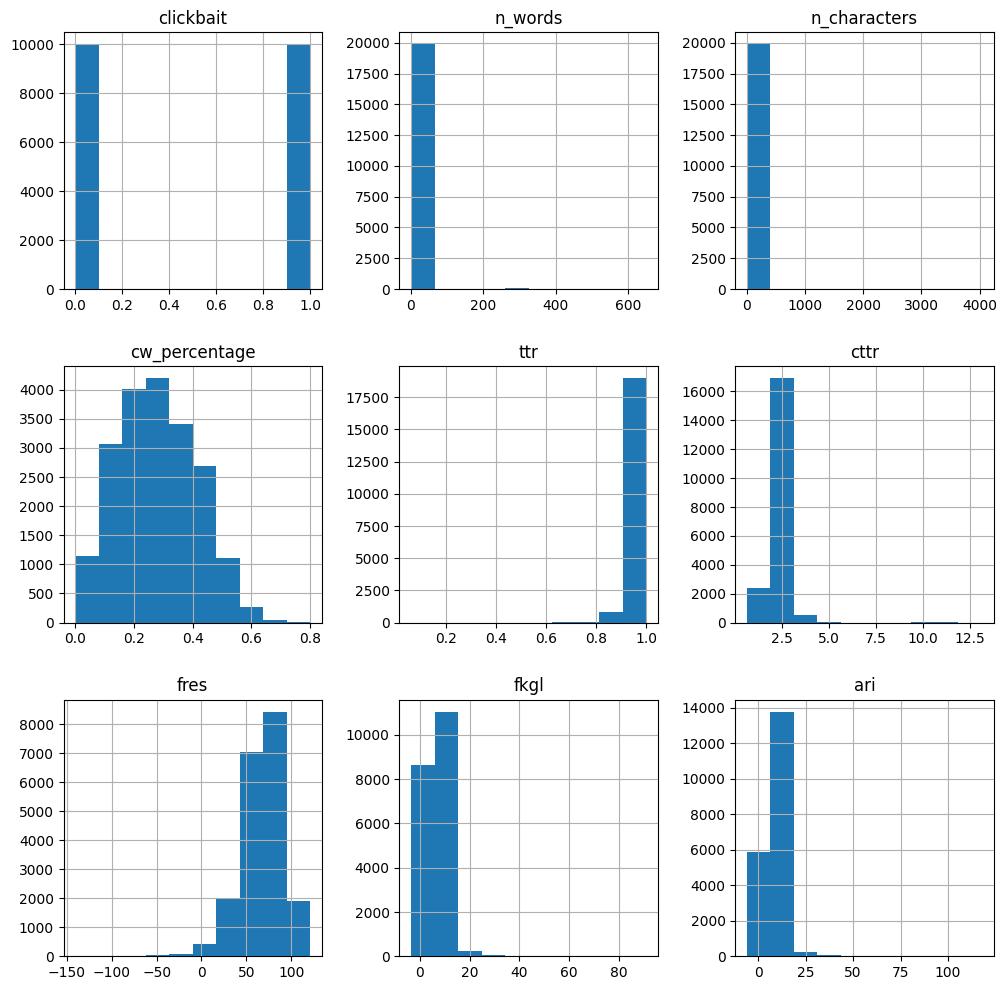

In [245]:
# check histograms
data_metrics.drop(['title', 'body'], axis=1).hist(figsize=(12,12))

Histograms for n_words and n_characters look bad. There some outliers, possibly because of flaws in data scraping, for example:

In [246]:
# example of problematic title
long_titles = data_metrics[data_metrics['n_words'] > 100]
long_titles['title'].iloc[0]

"Sections Shows Live Yahoo!-ABC News Network | © 2017 ABC News Internet Ventures. All rights reserved. ABC News DC Mansion Murders: Investigators Find Apparently Bloody Bat in House Apparently Bloody Bat Found in DC Mansion Case Trump was talking about general surveillance in wiretapping claims, Spicer says GOP congressman defends racially charged tweet against critics States seeking Trump travel ban block want new hearing Verizon sought $925 million penalty for Yahoo's lax security Abrupt dismissals leave US attorneys scrambling Shots fired at Ferguson protest sparked by new documentary Carlos the Jackal regrets not killing 'people I should have' Photography project captures 'first hello' between parents and newborns Pregnant woman rewards man who offered his seat with a custom trophy Mom reunited with lost family video found at Goodwill Villanova's 2016 March Madness win recreated with Legos Disinfecting agent turns Canada city's water bright pink Friar dog adopted by monastery becom

In [247]:
# mean
print(f"mean number of words: {round(np.mean(data_metrics['n_words']), 1)}\n")
# percentiles
q_percentiles = [90, 99, 99.5, 99.7]
percentiles = np.percentile(data_metrics['n_words'], q_percentiles)
print(f"Percentiles:\nq: {q_percentiles}\n{percentiles}")

mean number of words: 12.5

Percentiles:
q: [90, 99, 99.5, 99.7]
[ 16.     30.     36.    211.885]


In [253]:
# clickbait / non-clickbait ratio
long_titles = data_metrics[data_metrics['n_words'] > 40]
print("", long_titles['clickbait'].value_counts())

 clickbait
0    42
1    41
Name: count, dtype: int64


Looking at the percentiles we can safely delete all titles longer than 40 words, also the ratio of target variable won't be disturbed

In [254]:
# dropping outliers
shortened_metrics = data_metrics[data_metrics['n_words'] < 40]

array([[<Axes: title={'center': 'n_words'}>,
        <Axes: title={'center': 'n_characters'}>]], dtype=object)

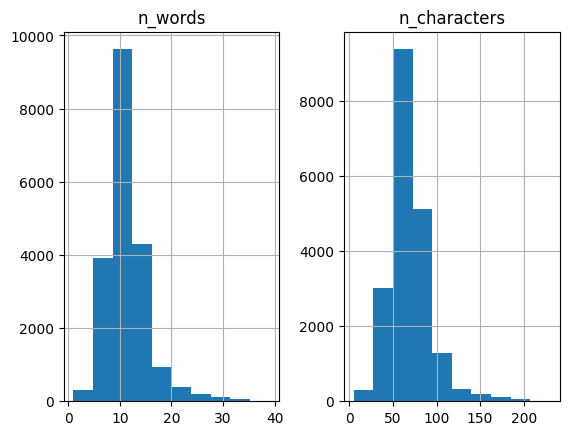

In [256]:
# check histograms again
shortened_metrics[['n_words', 'n_characters']].hist()

Now let's plot boxplots, as there we can find insights of the relationships of each variable with target var

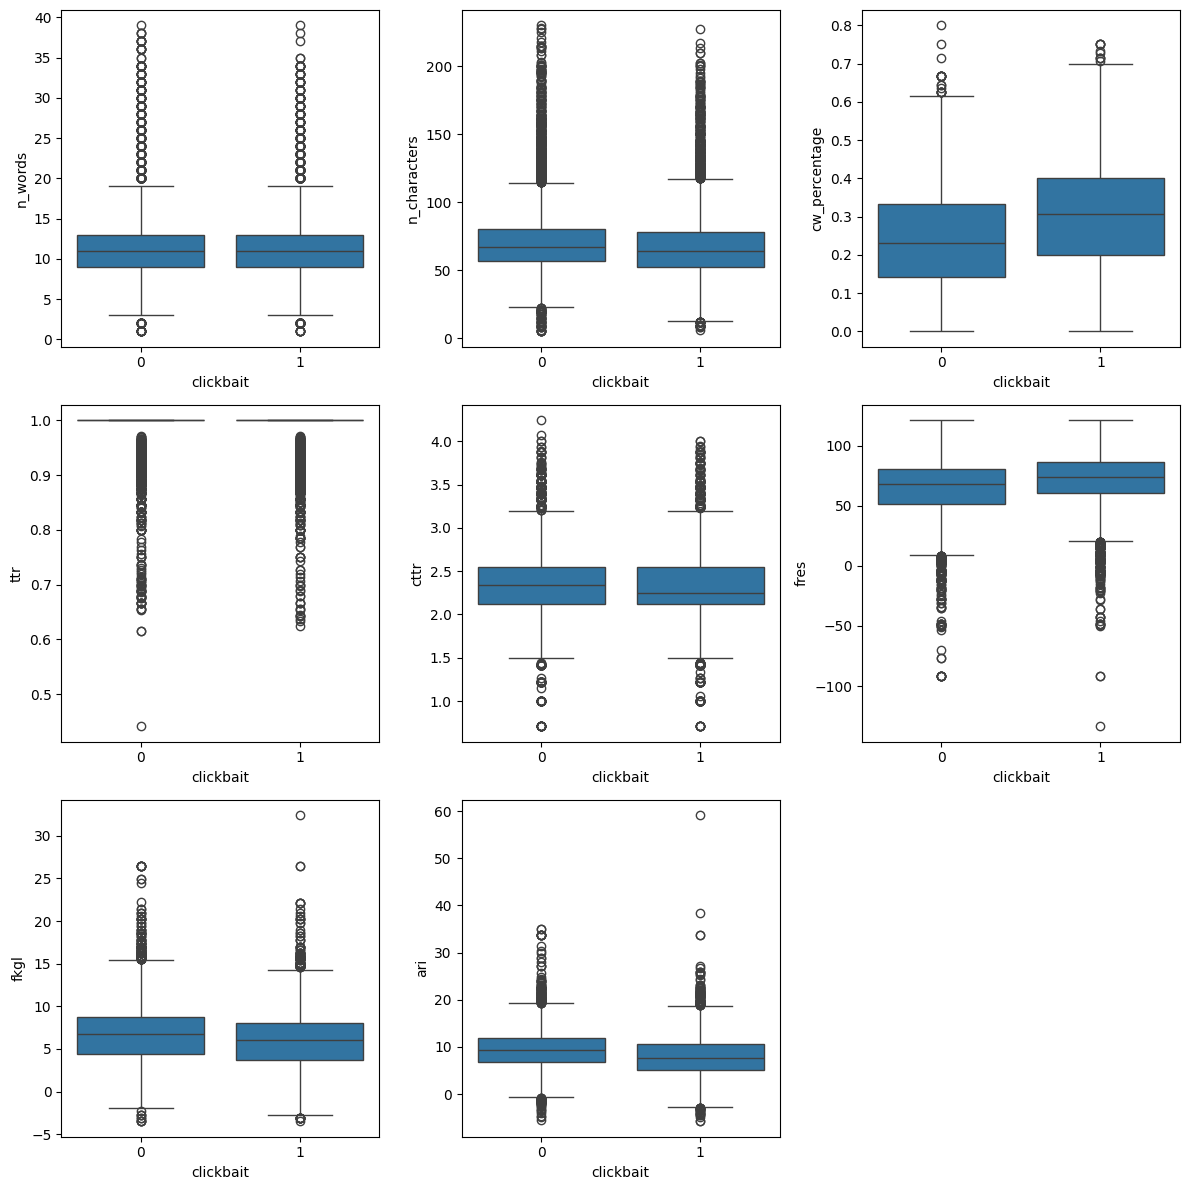

In [277]:
plt.figure(figsize=(12,12))
columns = shortened_metrics.columns.to_list()[3:]
for i, col in enumerate(columns):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x='clickbait', y=col, data=shortened_metrics)
plt.tight_layout()
plt.show()

Half of the measures have almost identical characteristics for bait and non-bait. There are differences for some variables, but they are rather not substantial (metrics measuring difficulty of the text). The only clear difference is in average percentage of common words, which is higher for clickbaits.

Fitting models:

In [428]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

import statsmodels.api as sm

<Axes: >

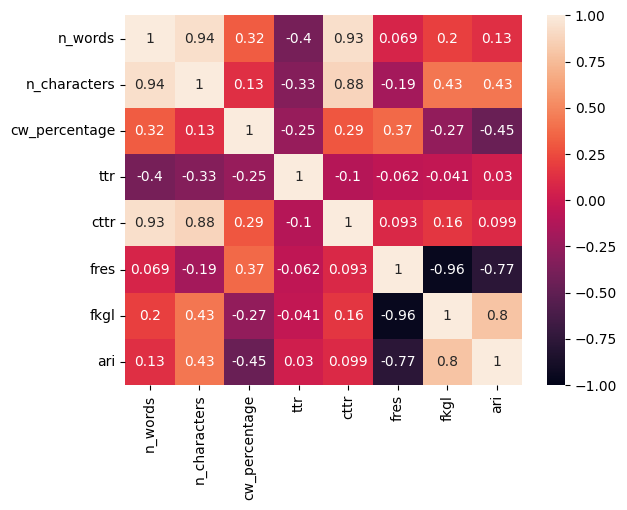

In [370]:
# check corelation
X = shortened_metrics.drop(['title', 'body', 'clickbait'], axis=1)
y = shortened_metrics['clickbait']

sns.heatmap(X.corr(), annot=True, vmax=1, vmin=-1)

<Axes: >

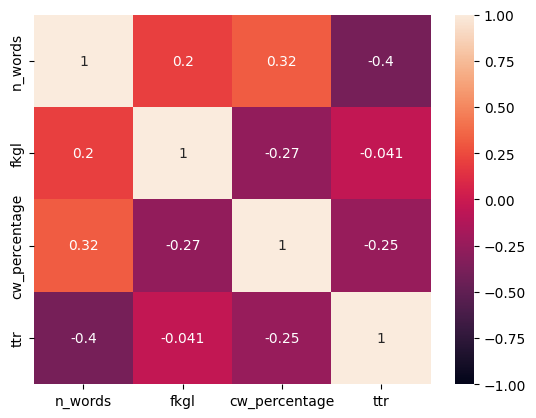

In [421]:
# dropping correlated columns 'n_characters', 'cttr', 'fres', 'ari'
X = shortened_metrics[['n_words', 'fkgl', 'cw_percentage', 'ttr']]
y = shortened_metrics['clickbait']

sns.heatmap(X.corr(), annot=True, vmax=1, vmin=-1)

In [423]:
# split and prepare data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
y_train = y_train.reset_index(drop=True)

In [425]:
# fit the model
log_reg = sm.Logit(y_train, X_train_scaled).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.655173
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              clickbait   No. Observations:                14894
Model:                          Logit   Df Residuals:                    14890
Method:                           MLE   Df Model:                            3
Date:                Thu, 10 Oct 2024   Pseudo R-squ.:                 0.05479
Time:                        13:48:38   Log-Likelihood:                -9758.1
converged:                       True   LL-Null:                       -10324.
Covariance Type:            nonrobust   LLR p-value:                6.232e-245
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
n_words          -0.1743      0.020     -8.608      0.000      -0.214      -0.135
fkgl             -0.

In [426]:
# make predictions
probs = log_reg.predict(X_test_scaled)
preds = [1 if prob > 0.5 else 0 for prob in probs]
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.60      0.63      0.61      2495
           1       0.61      0.57      0.59      2470

    accuracy                           0.60      4965
   macro avg       0.60      0.60      0.60      4965
weighted avg       0.60      0.60      0.60      4965



The only insignificant variable is ttr, so lets drop it and fit a model again

In [427]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(['ttr'], axis=1), y, random_state=42)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
y_train = y_train.reset_index(drop=True)

log_reg = sm.Logit(y_train, X_train_scaled).fit()
print(log_reg.summary())

probs = log_reg.predict(X_test_scaled)
preds = [1 if prob > 0.5 else 0 for prob in probs]
print(classification_report(y_test, preds))

Optimization terminated successfully.
         Current function value: 0.655192
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              clickbait   No. Observations:                14894
Model:                          Logit   Df Residuals:                    14891
Method:                           MLE   Df Model:                            2
Date:                Thu, 10 Oct 2024   Pseudo R-squ.:                 0.05476
Time:                        13:52:52   Log-Likelihood:                -9758.4
converged:                       True   LL-Null:                       -10324.
Covariance Type:            nonrobust   LLR p-value:                3.122e-246
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
n_words          -0.1794      0.019     -9.369      0.000      -0.217      -0.142
fkgl             -0.

We got better accuracy, but it's impossible to build a good model based only of informativeness measures of title. Also, most of them are correlated, so its enough to choose only some of them (eg n_words, fkgl, cw_percentage). 

For the sake of testing, lets put all the variables to random forest:

In [431]:
X = shortened_metrics.drop(['title', 'body', 'clickbait'], axis=1)
y = shortened_metrics['clickbait']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

preds = rf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.58      0.58      0.58      2495
           1       0.58      0.57      0.58      2470

    accuracy                           0.58      4965
   macro avg       0.58      0.58      0.58      4965
weighted avg       0.58      0.58      0.58      4965



#### Body analysis

## Tests

In [278]:
raw_data[raw_data['body'].str.contains('\xa0')]

,title,body,clickbait
0,"Quality Street, eggnog and sing-offs against T...",I grew up in a chilly house with a depressed m...,0
1,There’s no evidence that Trump’s inauguration ...,It truly couldn’t matter less how many people ...,0
2,US Ambassador Samantha Power: Russia is 'teari...,"Reuters Jan. 17, 2017, 1:47 PM 1,594 facebook ...",0
3,This woman's outraged response to the general ...,"When it comes to politics, British people agre...",0
5,A family found a rattlesnake in their toilet —...,What was supposed to be a normal morning in th...,0
...,...,...,...
19992,Lowry: Paul Ryan Thinks Trump Will Just Sign G...,"Sunday on NBC’s “Meet the Press,” National Rev...",1
19993,Kim Kardashian surrounds herself with the Nort...,There are some advent calendars that give you ...,1
19994,Pak Defense Minister Threatens To Nuke Israel ...,"Pakistan's defense minister, Khawaja Muhammad ...",1
19996,Railway Ticket Collector Bites Nose Of His Bos...,Ticket examiners in India have a tendency to g...,1
